<a href="https://colab.research.google.com/github/katha815/ADME-Classifier/blob/main/Data_size_estimation_extraploting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization (base path defined)
Feature groups: (1)6 phastCons scores, (2)6 phyloP scores, (3)vepDistance, (4){A-C,A-G,A-T,C-A,...}categorical input, (5)Ensemble search consequence , (6)corresponding SIFT and Polyphen scores, (7) popoulation frequencies.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from xgboost import XGBClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
!pip install scikit-optimize
import skopt
from skopt import BayesSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from skopt.space import Real, Categorical, Integer

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
base = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/"

# Odata loading and testing/training split preparation

In [ ]:
# Import data
data2 = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/ADME Project/Odata_fzero_noP.csv")
# One hot encode with get_dummies
print(f"Whole data: {data2}\n")
Y = data2['Label']
X = data2[[col for col in data2.columns if col!="Location1" and col!="Location2" and
           col!="chr" and col!="Label" and col!="Ref" and col!="Alter"and col!="baseChange"]]
print(X,'\n')
pd.set_option('display.max_rows', None)  # Set the max_rows option to None to show all rows
pd.set_option('display.max_columns', None)  # Set the max_columns option to None to show all columns
print(X.dtypes,'\n')
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
print(Y,'\n')

Whole data:     Chromo  Location1  Location2 Ref Alter  Label  chr  transcript_ablation  \
0     chr1   46930150   46930150   C     T      1    1                    0   
1     chr1   46930161   46930161   G     A      1    1                    0   
2     chr1   46932824   46932824   T     C      1    1                    0   
3     chr1   46932987   46932987   C     T      1    1                    0   
4     chr1   46934207   46934207   A     G      0    1                    0   
..     ...        ...        ...  ..   ...    ...  ...                  ...   
329  chr22   42129836   42129836   C     T      0   22                    0   
330  chr22   42130692   42130692   C     T      1   22                    0   
331  chr22   42130710   42130710   C     T      0   22                    0   
332  chr22   42130715   42130715   G     A      1   22                    0   
333  chr22   42130761   42130761   G     A      1   22                    0   

     splice_acceptor_variant  splice_do

In [ ]:
## Prepare leave one chromosome out split indexes
chrom_values = X['Chromo'].unique()
grouped = X.groupby(['Chromo'])

# Initialization
datasplit = []
labels = []
combined_index = [None for _ in range(chrom_values.shape[0])]
testlist = [None for _ in range(chrom_values.shape[0])]
trainlist = [None for _ in range(chrom_values.shape[0])]

# Extract info from grouped data
for n in range(chrom_values.shape[0]):
    chrom_i = chrom_values[n]
    new_data = grouped.get_group(chrom_i)  # Generate random data
    label = f"{chrom_i}"  # Generate label
    datasplit.append(new_data)  # Store data
    labels.append(label)  # Store label
print(type(datasplit[0].index),np.shape(datasplit[0].index))
print(datasplit[0].index.tolist())

# Convert it to chromo label and chromo-splitted testing sets
for i in range(len(labels)):
    print(f"Chromosome: {labels[i]}:")
    # print(f"Iteration: {i+1}\n")
    # print(f"Data_index: {datasplit[i].index}")
    print(f"Data_size: {len(datasplit[i])}")
    testlist[i] = np.array(datasplit[i].index).tolist()
    # print(f"Test size: {len(testlist[i])}\n")
    print(f"Test indexes: {testlist[i]}\n")
    # Label: {labels[i]}\n {type(testlist[i])}\n")

# Always merge the shortest lists, make sure the minimum length<20
while min(map(len, testlist)) < 20 and len(testlist) > 1:
    idx1, idx2 = sorted(range(len(testlist)), key=lambda i: len(testlist[i]))[:2] #not including 2, so 0/1
    print(testlist[idx1], testlist[idx2])
    testlist[idx1] = testlist[idx1] + testlist[idx2]
    testlist.pop(idx2)
# Check merged-testing sets length:
for x in testlist:
    print(f"Test size: {len(x)};")

# Validation list: order = order+1 for the testlist
vlist = testlist[1:] + [testlist[0]]
for x in vlist:
    print(f"Validation size: {len(x)};")

# Build training sets accordingly
all = list(range(len(X)))
# print(all)
trainlist = []
for i, test_indexes in enumerate(testlist):
    train_indexes = np.array([index for index in all if index not in test_indexes])
    trainlist.append(train_indexes)
for x in trainlist:
    print(f"Train size: {len(x)};")
    # print(f"Train size: {len(trainlist[i])}\n")
    # print(f"Train indexes: {trainlist[i]}\n {type(trainlist[i])}\n")

<class 'pandas.core.indexes.numeric.Int64Index'> (18,)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Chromosome: chr1:
Data_size: 18
Test indexes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

Chromosome: chr2:
Data_size: 28
Test indexes: [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]

Chromosome: chr3:
Data_size: 8
Test indexes: [46, 47, 48, 49, 50, 51, 52, 53]

Chromosome: chr4:
Data_size: 8
Test indexes: [54, 55, 56, 57, 58, 59, 60, 61]

Chromosome: chr6:
Data_size: 42
Test indexes: [62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103]

Chromosome: chr7:
Data_size: 11
Test indexes: [104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114]

Chromosome: chr8:
Data_size: 29
Test indexes: [115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,

In [ ]:
updated_trainlist = []
for i, test_indexes in enumerate(trainlist):
    v_indexes = vlist[i]
    updated_test_indexes = np.array([index for index in test_indexes if index not in v_indexes])
    updated_trainlist.append(updated_test_indexes)
for x in updated_trainlist:
    print(f"Train size: {len(x)};")

Train size: 264;
Train size: 263;
Train size: 276;
Train size: 218;
Train size: 227;
Train size: 280;
Train size: 270;
Train size: 269;
Train size: 271;


In [ ]:
# Finalizing with scaling
from sklearn.preprocessing import StandardScaler
X = X.drop('Chromo', axis=1)
X = np.array([X.values.tolist()]).reshape(X.shape[0],-1)
Y = np.array([Y.values.tolist()]).reshape(X.shape[0],)
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
base = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/"

# Baye's Model - data read from ssh results

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[14.0, 30.0, 43.0, 60.0, 74.0, 90.0, 104.0, 121.0, 135.0, 149.0, 164.0, 178.0, 195.0, 209.0, 225.0, 239.0, 256.0, 269.0, 285.0, 299.0, 15.0, 31.0, 44.0, 61.0, 76.0, 92.0, 106.0, 124.0, 138.0, 153.0, 168.0, 182.0, 200.0, 213.0, 230.0, 245.0, 262.0, 276.0, 291.0, 306.0, 14.0, 30.0, 42.0, 59.0, 73.0, 87.0, 101.0, 118.0, 132.0, 146.0, 160.0, 174.0, 191.0, 204.0, 219.0, 233.0, 250.0, 263.0, 278.0, 292.0, 15.0, 31.0, 44.0, 61.0, 76.0, 91.0, 106.0, 123.0, 138.0, 153.0, 167.0, 182.0, 199.0, 213.0, 229.0, 244.0, 261.0, 275.0, 290.0, 305.0, 15.0, 31.0, 44.0, 61.0, 76.0, 91.0, 106.0, 123.0, 138.0, 153.0, 167.0, 182.0, 199.0, 213.0, 229.0, 244.0, 261.0, 275.0, 290.0, 305.0, 12.0, 25.0, 35.0, 50.0, 61.0, 74.0, 86.0, 100.0, 112.0, 123.0, 135.0, 147.0, 161.0, 172.0, 186.0, 197.0, 212.0, 223.0, 235.0, 247.0, 15.0, 32.0, 45.0, 63.0, 78.0, 94.0, 109.0, 127.0, 142.0, 157.0, 1

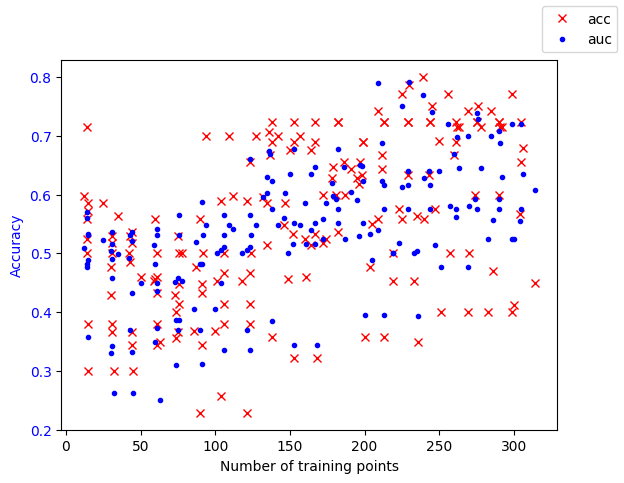

In [ ]:
# DataS: Test the stored data reading
import csv
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/gdrive')
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [float(element) for element in row]
            data.append(row_data)
        data = data[0]
    return data
base = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/"
base_path1 = f"{base}/dataS/by_trial2/"
size = read_csv(f"{base_path1}size.csv")
acc_scores = read_csv(f"{base_path1}acc_scores.csv")
auc_scores = read_csv(f"{base_path1}auc_scores.csv")
print(size,"\n",acc_scores,"\n",auc_scores,"\n")
# Trial 1 Plot 1
fig, ax1 = plt.subplots()
ax1.plot(size, acc_scores, 'rx', label = 'acc')
ax1.plot(size, auc_scores, 'b.', label = 'auc')
ax1.set_xlabel('Number of training points')
ax1.set_ylabel('Accuracy',color='b')
ax1.tick_params(axis='y',labelcolor='b')
fig.legend()
plt.show()
fig.savefig(f"{base_path1}dataS_E_scatter.png")

In [ ]:
base = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/"

In [ ]:
def opt_ave_list(original_list, num_subgroups):
    # Calculate the number of elements per subgroup
    elements_per_subgroup = len(original_list) // num_subgroups

    # Create subgroups
    subgroups = [original_list[i:i+elements_per_subgroup] for i in range(0, len(original_list), elements_per_subgroup)]

    # Calculate average values for each nth element
    average_values = []
    for n in range(1, elements_per_subgroup + 1):
        avg = sum(subgroup[n - 1] for subgroup in subgroups) / num_subgroups
        average_values.append(avg)

    return average_values

# Example usage:
original_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
                 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
                 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]

num_subgroups = 2  # Change this to the desired number of subgroups
average_values = opt_ave_list(original_list, num_subgroups)
print(average_values)

[11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0]


[14.0, 30.0, 43.0, 60.0, 74.0, 90.0, 104.0, 121.0, 135.0, 149.0, 164.0, 178.0, 195.0, 209.0, 225.0, 239.0, 256.0, 269.0, 285.0, 299.0, 15.0, 31.0, 44.0, 61.0, 76.0, 92.0, 106.0, 124.0, 138.0, 153.0, 168.0, 182.0, 200.0, 213.0, 230.0, 245.0, 262.0, 276.0, 291.0, 306.0, 14.0, 30.0, 42.0, 59.0, 73.0, 87.0, 101.0, 118.0, 132.0, 146.0, 160.0, 174.0, 191.0, 204.0, 219.0, 233.0, 250.0, 263.0, 278.0, 292.0, 15.0, 31.0, 44.0, 61.0, 76.0, 91.0, 106.0, 123.0, 138.0, 153.0, 167.0, 182.0, 199.0, 213.0, 229.0, 244.0, 261.0, 275.0, 290.0, 305.0, 15.0, 31.0, 44.0, 61.0, 76.0, 91.0, 106.0, 123.0, 138.0, 153.0, 167.0, 182.0, 199.0, 213.0, 229.0, 244.0, 261.0, 275.0, 290.0, 305.0, 12.0, 25.0, 35.0, 50.0, 61.0, 74.0, 86.0, 100.0, 112.0, 123.0, 135.0, 147.0, 161.0, 172.0, 186.0, 197.0, 212.0, 223.0, 235.0, 247.0, 15.0, 32.0, 45.0, 63.0, 78.0, 94.0, 109.0, 127.0, 142.0, 157.0, 172.0, 187.0, 205.0, 219.0, 236.0, 251.0, 269.0, 283.0, 299.0, 314.0, 14.0, 31.0, 43.0, 60.0, 75.0, 90.0, 104.0, 121.0, 136.0, 150.0

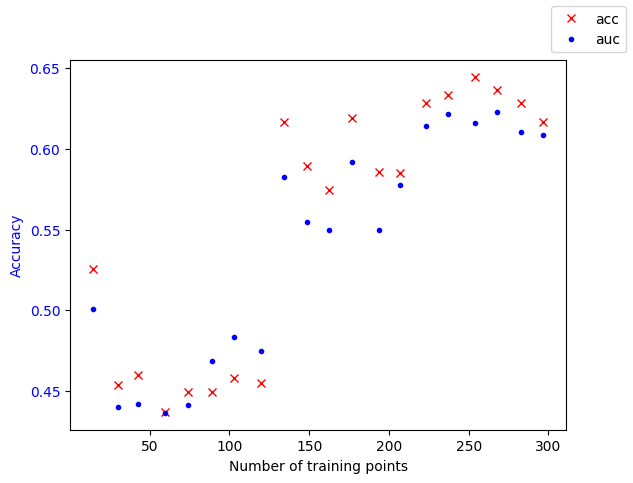

In [ ]:
# DataS: Plot with averaged values - baye new algorithm 2
base = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/"
base_path1 = f"{base}/dataS/by_trial2/"
size = read_csv(f"{base_path1}size.csv")
acc_scores = read_csv(f"{base_path1}acc_scores.csv")
auc_scores = read_csv(f"{base_path1}auc_scores.csv")
print(size,"\n",acc_scores,"\n",auc_scores,"\n")
fig, ax1 = plt.subplots()
ave_size = opt_ave_list(size, 9)
ave_acc = opt_ave_list(acc_scores, 9)
ave_auc = opt_ave_list(auc_scores, 9)
ax1.plot(ave_size, ave_acc, 'rx', label = 'acc')
ax1.plot(ave_size, ave_auc, 'b.', label = 'auc')
ax1.set_xlabel('Number of training points')
ax1.set_ylabel('Accuracy',color='b')
ax1.tick_params(axis='y',labelcolor='b')
fig.legend()
plt.show()
fig.savefig(f"{base_path1}dataS_E_scatter.png")

[-1.08517896e+03  1.08596786e+03  6.53233630e-05]


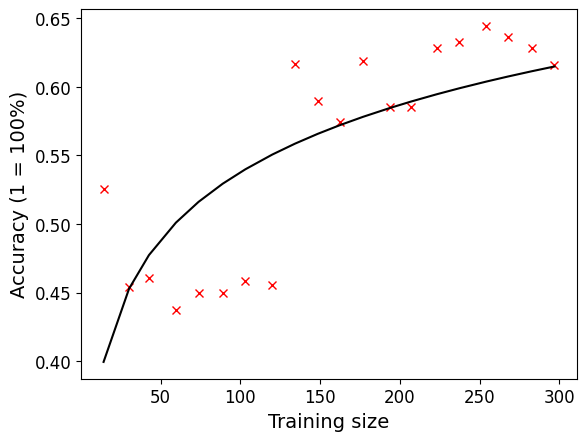

In [ ]:
# DataS: Find error curve of acc - baye new algorithm 2
from scipy.optimize import curve_fit
import numpy as np
base = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/"
base_path1 = f"{base}/dataS/"
def inverse_power(x, a, b, c):
    return (1-a)-b*(x**(-c))
pars, cov = curve_fit(f=inverse_power, xdata=ave_size, ydata=ave_acc, maxfev=5000,\
            p0=[0.1, 0.1, 0.1], bounds=(-np.inf, np.inf))
print(pars)
# Trial 2 Plot 2
fig, ax1 = plt.subplots()
# ax1.plot(size, acc_scores, 'r.')
ax1.plot(ave_size, ave_acc, 'rx')
ax1.plot(ave_size, inverse_power(ave_size, *pars), 'k-')
ax1.set_xlabel('Training size',size=14)
ax1.set_ylabel('Accuracy (1 = 100%)',
               size=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.savefig(f"{base_path1}dataS_Baye_ave_scatter.png",bbox_inches='tight')

In [ ]:
# DataS: Find dataS for 90% acc - baye new algorithm 2
from scipy.optimize import fsolve
def func(x):
    return inverse_power(x, *pars)
def difference(x):
    return func(x) - 0.9
root = fsolve(difference, 300) # Find the root when the function is shifted by 0.9, initial value = 253

print(np.isclose(difference(root),0))  # func(root) should be almost 0.0.
print(root,'\n')
print(func(root))

[ True]
[16551.61233029] 

[0.9]


**Conclusion**: for Baye's Model, if training data size reaches 16551, we may get a 90% accuracy of prediction!

[-1.02151012e+03  1.02230065e+03  6.70727012e-05]


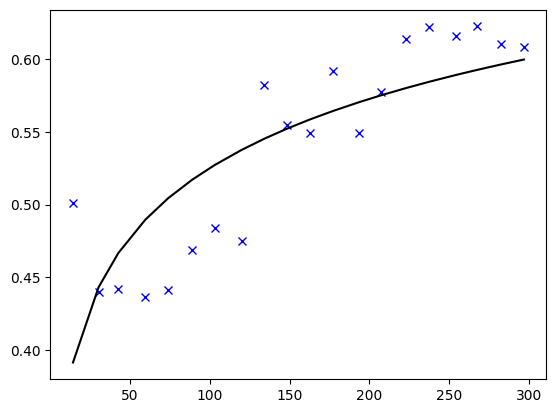

In [ ]:
# DataS: Find error curve of auc - baye new algorithm 2
from scipy.optimize import curve_fit
import numpy as np
def inverse_power(x, a, b, c):
    return (1-a)-b*(x**(-c))
pars, cov = curve_fit(f=inverse_power, xdata=ave_size, ydata=ave_auc, maxfev=5000,\
                      p0=[0.1, 0.1, 0.1], bounds=(-np.inf, np.inf))
print(pars)
# Trial 2 Plot 2
fig, ax1 = plt.subplots()
# ax1.plot(size, auc_scores, 'r.')
ax1.plot(ave_size, ave_auc, 'bx')
ax1.plot(ave_size, inverse_power(ave_size, *pars), 'k-')

In [ ]:
# DataS: Find dataS for 0.9 auc - baye new algorithm 2
from scipy.optimize import fsolve
def func(x):
    return inverse_power(x, *pars)
def difference(x):
    return func(x) - 0.9
root = fsolve(difference, 300) # Find the root when the function is shifted by 0.9, initial value = 253

print(np.isclose(difference(root),0))  # func(root) should be almost 0.0.
print(root,'\n')
print(func(root))

[ True]
[23721.69750533] 

[0.9]


**Conclusion**: for Baye's Model, if training data size reaches 23722, we may get a 0.9 ROC_AUC for predictions!

# SVM Model - data read from ssh results

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[14.0, 30.0, 43.0, 60.0, 74.0, 90.0, 104.0, 121.0, 135.0, 149.0, 164.0, 178.0, 195.0, 209.0, 225.0, 239.0, 256.0, 269.0, 285.0, 299.0, 15.0, 31.0, 44.0, 61.0, 76.0, 92.0, 106.0, 124.0, 138.0, 153.0, 168.0, 182.0, 200.0, 213.0, 230.0, 245.0, 262.0, 276.0, 291.0, 306.0, 14.0, 30.0, 42.0, 59.0, 73.0, 87.0, 101.0, 118.0, 132.0, 146.0, 160.0, 174.0, 191.0, 204.0, 219.0, 233.0, 250.0, 263.0, 278.0, 292.0, 15.0, 31.0, 44.0, 61.0, 76.0, 91.0, 106.0, 123.0, 138.0, 153.0, 167.0, 182.0, 199.0, 213.0, 229.0, 244.0, 261.0, 275.0, 290.0, 305.0, 15.0, 31.0, 44.0, 61.0, 76.0, 91.0, 106.0, 123.0, 138.0, 153.0, 167.0, 182.0, 199.0, 213.0, 229.0, 244.0, 261.0, 275.0, 290.0, 305.0, 12.0, 25.0, 35.0, 50.0, 61.0, 74.0, 86.0, 100.0, 112.0, 123.0, 135.0, 147.0, 161.0, 172.0, 186.0, 197.0, 212.0, 223.0, 235.0, 247.0, 15.0, 32.0, 45.0, 63.0, 78.0, 94.0, 109.0, 127.0, 142.0, 157.0, 1

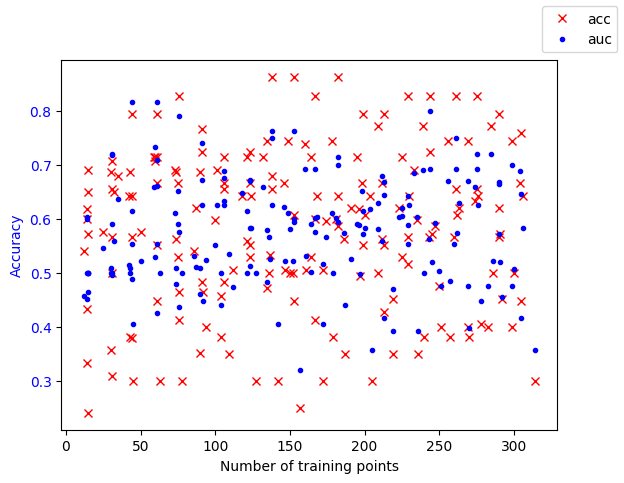

In [ ]:
# DataS: Test the stored data reading
import csv
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/gdrive')
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [float(element) for element in row]
            data.append(row_data)
        data = data[0]
    return data
base = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/"
base_path1 = f"{base}/dataS/svm_trial2/"
size = read_csv(f"{base_path1}size.csv")
acc_scores = read_csv(f"{base_path1}acc_scores.csv")
auc_scores = read_csv(f"{base_path1}auc_scores.csv")
print(size,"\n",acc_scores,"\n",auc_scores,"\n")
# Trial 1 Plot 1
fig, ax1 = plt.subplots()
ax1.plot(size, acc_scores, 'rx', label = 'acc')
ax1.plot(size, auc_scores, 'b.', label = 'auc')
ax1.set_xlabel('Number of training points')
ax1.set_ylabel('Accuracy',color='b')
ax1.tick_params(axis='y',labelcolor='b')
fig.legend()
plt.show()
fig.savefig(f"{base_path1}dataS_E_scatter.png")

In [ ]:
def opt_ave_list(original_list, num_subgroups):
    # Calculate the number of elements per subgroup
    elements_per_subgroup = len(original_list) // num_subgroups

    # Create subgroups
    subgroups = [original_list[i:i+elements_per_subgroup] for i in range(0, len(original_list), elements_per_subgroup)]

    # Calculate average values for each nth element
    average_values = []
    for n in range(1, elements_per_subgroup + 1):
        avg = sum(subgroup[n - 1] for subgroup in subgroups) / num_subgroups
        average_values.append(avg)

    return average_values

# Example usage:
original_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
                 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
                 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]

num_subgroups = 2  # Change this to the desired number of subgroups
average_values = opt_ave_list(original_list, num_subgroups)
print(average_values)

[11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0]


[14.0, 30.0, 43.0, 60.0, 74.0, 90.0, 104.0, 121.0, 135.0, 149.0, 164.0, 178.0, 195.0, 209.0, 225.0, 239.0, 256.0, 269.0, 285.0, 299.0, 15.0, 31.0, 44.0, 61.0, 76.0, 92.0, 106.0, 124.0, 138.0, 153.0, 168.0, 182.0, 200.0, 213.0, 230.0, 245.0, 262.0, 276.0, 291.0, 306.0, 14.0, 30.0, 42.0, 59.0, 73.0, 87.0, 101.0, 118.0, 132.0, 146.0, 160.0, 174.0, 191.0, 204.0, 219.0, 233.0, 250.0, 263.0, 278.0, 292.0, 15.0, 31.0, 44.0, 61.0, 76.0, 91.0, 106.0, 123.0, 138.0, 153.0, 167.0, 182.0, 199.0, 213.0, 229.0, 244.0, 261.0, 275.0, 290.0, 305.0, 15.0, 31.0, 44.0, 61.0, 76.0, 91.0, 106.0, 123.0, 138.0, 153.0, 167.0, 182.0, 199.0, 213.0, 229.0, 244.0, 261.0, 275.0, 290.0, 305.0, 12.0, 25.0, 35.0, 50.0, 61.0, 74.0, 86.0, 100.0, 112.0, 123.0, 135.0, 147.0, 161.0, 172.0, 186.0, 197.0, 212.0, 223.0, 235.0, 247.0, 15.0, 32.0, 45.0, 63.0, 78.0, 94.0, 109.0, 127.0, 142.0, 157.0, 172.0, 187.0, 205.0, 219.0, 236.0, 251.0, 269.0, 283.0, 299.0, 314.0, 14.0, 31.0, 43.0, 60.0, 75.0, 90.0, 104.0, 121.0, 136.0, 150.0

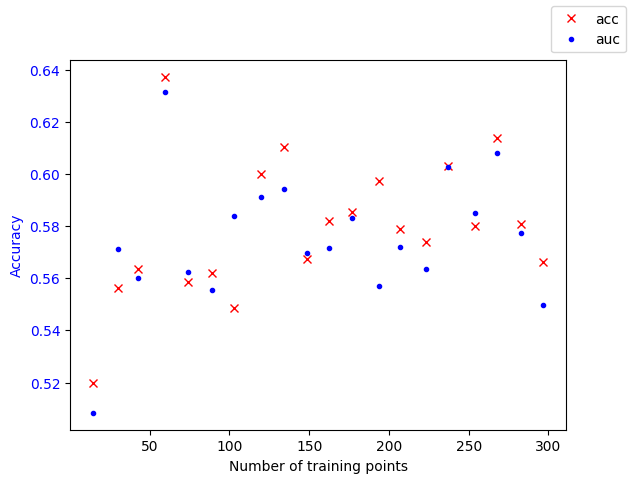

In [ ]:
# DataS: Plot with averaged values - baye new algorithm 2
base = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/"
base_path1 = f"{base}/dataS/svm_trial2/"
size = read_csv(f"{base_path1}size.csv")
acc_scores = read_csv(f"{base_path1}acc_scores.csv")
auc_scores = read_csv(f"{base_path1}auc_scores.csv")
print(size,"\n",acc_scores,"\n",auc_scores,"\n")
fig, ax1 = plt.subplots()
ave_size = opt_ave_list(size, 9)
ave_acc = opt_ave_list(acc_scores, 9)
ave_auc = opt_ave_list(auc_scores, 9)
ax1.plot(ave_size, ave_acc, 'rx', label = 'acc')
ax1.plot(ave_size, ave_auc, 'b.', label = 'auc')
ax1.set_xlabel('Number of training points')
ax1.set_ylabel('Accuracy',color='b')
ax1.tick_params(axis='y',labelcolor='b')
fig.legend()
plt.show()
fig.savefig(f"{base_path1}dataS_E_scatter.png")

[0.41316401 2.98320984 1.42396237]


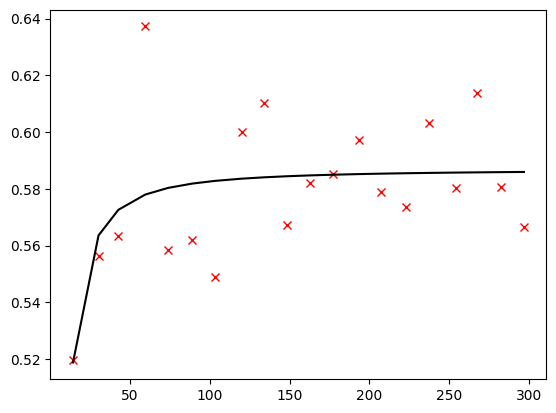

In [ ]:
# DataS: Find error curve of acc - baye new algorithm 2
from scipy.optimize import curve_fit
import numpy as np
def inverse_power(x, a, b, c):
    return (1-a)-b*(x**(-c))
pars, cov = curve_fit(f=inverse_power, xdata=ave_size, ydata=ave_acc, maxfev=5000,\
            p0=[0.1, 0.1, 0.1], bounds=(-np.inf, np.inf))
print(pars)
# Trial 2 Plot 2
fig, ax1 = plt.subplots()
# ax1.plot(size, acc_scores, 'r.')
ax1.plot(ave_size, ave_acc, 'rx')
ax1.plot(ave_size, inverse_power(ave_size, *pars), 'k-')

In [ ]:
# DataS: Find dataS for 90% acc - baye new algorithm 2
from scipy.optimize import fsolve
def func(x):
    return inverse_power(x, *pars)
def difference(x):
    return func(x) - 0.9
root = fsolve(difference, 300) # Find the root when the function is shifted by 0.9, initial value = 253

print(np.isclose(difference(root),0))  # func(root) should be almost 0.0.
print(root,'\n')
print(func(root))

[False]
[3877800.] 

[0.58683599]


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


**Conclusion**: For SVM model, with binary prediction 90% accuracy not achievable by increasing training size!

[  0.42102991 230.52020811   3.04694169]


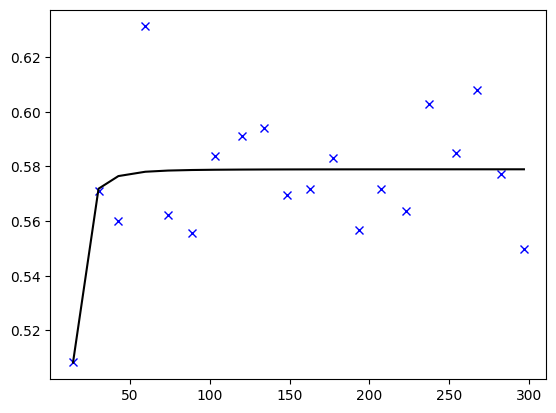

In [ ]:
# DataS: Find error curve of auc - baye new algorithm 2
from scipy.optimize import curve_fit
import numpy as np
def inverse_power(x, a, b, c):
    return (1-a)-b*(x**(-c))
pars, cov = curve_fit(f=inverse_power, xdata=ave_size, ydata=ave_auc, maxfev=5000,\
                      p0=[0.1, 0.1, 0.1], bounds=(-np.inf, np.inf))
print(pars)
# Trial 2 Plot 2
fig, ax1 = plt.subplots()
# ax1.plot(size, auc_scores, 'r.')
ax1.plot(ave_size, ave_auc, 'bx')
ax1.plot(ave_size, inverse_power(ave_size, *pars), 'k-')

In [ ]:
# DataS: Find dataS for 0.9 auc - baye new algorithm 2
from scipy.optimize import fsolve
def func(x):
    return inverse_power(x, *pars)
def difference(x):
    return func(x) - 0.9
root = fsolve(difference, 300) # Find the root when the function is shifted by 0.9, initial value = 253

print(np.isclose(difference(root),0))  # func(root) should be almost 0.0.
print(root,'\n')
print(func(root))

[False]
[506550.] 

[0.57897009]


**Conclusion**: For SVM model, with binary prediction 0.9 ROC_AUC not achievable by increasing training size!

# SVM Model with thres - data read from ssh results (need to use bast_params)

## Read best_params and test model built by best_params

In [ ]:
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [element for element in row]
            data.append(row_data)
    return data
path = f"{base}dataS/svm_trial2/best_params_0.csv"
paras_l = read_csv(path)
paras_l = paras_l[0]
import ast
def convert_to_dict(entry):
    ordered_dict_str = entry.replace("OrderedDict", "")  # Remove 'OrderedDict' to have a valid dictionary string
    ordered_dict = ast.literal_eval(ordered_dict_str)
    return dict(ordered_dict)
converted_paras_l = [convert_to_dict(entry) for entry in paras_l]
# converted_paras_l

In [ ]:
from sklearn.svm import SVC
from skopt.space import Real, Categorical, Integer
def create_svm_model(svc__C, svc__kernel, svc__gamma, svc__degree):
   model = make_pipeline(StandardScaler(), SVC(C=svc__C, kernel=svc__kernel,
        gamma=svc__gamma, degree=svc__degree, probability=True, random_state=42))
   return model

In [ ]:
def convert(pred_probs, thres):
    converted_preds = np.empty(len(pred_probs), dtype=object)
    # print(pred_probs)
    for i in range(len(pred_probs)):
        # print(pred_probs[i])
        prob_class_0 = pred_probs[i][0]
        prob_class_1 = pred_probs[i][1]
        if prob_class_0 > thres:
            converted_preds[i] = 0
        elif prob_class_1 > thres:
            converted_preds[i] = 1
        else:
            converted_preds[i] = np.nan
    return converted_preds

def prob_acc(y_test, preds, thres):
    converted_preds = convert(preds, thres)
    converted_preds = converted_preds#.tolist()
    converted_preds = [float(pred) for pred in converted_preds]
    # print(type(converted_preds[0]))
    nan_indices = np.argwhere(np.isnan(converted_preds)).flatten()#.tolist()
    # print(type(nan_indices),type(nan_indices[0]))
    # print(nan_indices)
    valid_converted_preds = [converted_preds[i] for i in range(len(converted_preds)) if not i in nan_indices]
    # print(len(valid_converted_preds))
    valid_y_test = [y_test[i] for i in range(len(y_test)) if not i in nan_indices]
    accuracy = 0
    if len(valid_y_test) != 0:
      accuracy = accuracy_score(valid_y_test, valid_converted_preds)
    omitted_percentage = (len(nan_indices) / len(converted_preds)) * 100
    return accuracy, omitted_percentage

def prob_auc(y_test, preds, thres):
    converted_preds = convert(preds, thres)
    converted_preds = converted_preds#.tolist()
    converted_preds = [float(pred) for pred in converted_preds]
    # print(type(converted_preds[0]))
    nan_indices = np.argwhere(np.isnan(converted_preds)).flatten()#.tolist()
    # print(type(nan_indices),type(nan_indices[0]))
    # print(nan_indices)
    valid_converted_preds = [converted_preds[i] for i in range(len(converted_preds)) if not i in nan_indices]
    # print(len(valid_converted_preds))
    valid_y_test = [y_test[i] for i in range(len(y_test)) if not i in nan_indices]
    accuracy = 0
    if len(valid_y_test) > 2:
      accuracy = roc_auc_score(valid_y_test, valid_converted_preds)
    omitted_percentage = (len(nan_indices) / len(converted_preds)) * 100
    return accuracy, omitted_percentage

*Pick a threshold from thres graph: 0.7 for noP training group

In [ ]:
params_list = []
for i in range(len(testlist)):
  path = f"{base}dataS/svm_trial2/best_params_{i}.csv"
  paras_l = read_csv(path)
  paras_l = paras_l[0]
  converted_paras_l = [convert_to_dict(entry) for entry in paras_l]
  params_list.append(converted_paras_l)
print(len(params_list))
print(params_list[1])

9
[{'svc__C': 0.2487161762119923, 'svc__degree': 5, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}, {'svc__C': 37.969706712764555, 'svc__degree': 1, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}, {'svc__C': 1.0622740042546142, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'sigmoid'}, {'svc__C': 0.8150487188520681, 'svc__degree': 5, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}, {'svc__C': 1.0899870108448333, 'svc__degree': 4, 'svc__gamma': 'auto', 'svc__kernel': 'linear'}, {'svc__C': 5.598000828167952, 'svc__degree': 3, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}, {'svc__C': 0.010644695764803933, 'svc__degree': 1, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}, {'svc__C': 0.11905958151626037, 'svc__degree': 4, 'svc__gamma': 'scale', 'svc__kernel': 'sigmoid'}, {'svc__C': 0.17145024518640184, 'svc__degree': 2, 'svc__gamma': 'auto', 'svc__kernel': 'sigmoid'}, {'svc__C': 1.5302312197081351, 'svc__degree': 2, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}, {'svc__C': 0.27134766838956

In [ ]:
from sklearn.model_selection import PredefinedSplit
import csv
#Testing loop
base_path1 = f"{base}dataS/"
acc_scores_a = []
# auc_scores_a = []
#Abandoned: Error about too few valid predictions/it is not proven to
#be suitable for error curve drawing.
o_ps_a = []
size_a = []
#Loop 0: Use different holdout/testing data set
for shuttle_i in range(len(testlist)):#len(testlist)-1
  print(f"Shuttle {shuttle_i}")
  best_params_l = params_list[shuttle_i]
  acc_scores = []
  # auc_scores = []
  o_ps = []
  size = []
  #Loop 1: training from 1/20 of each chr, increase the portion by each iteration
  for r in range(1, 21): #r: ratio of training folds
    best_params = best_params_l[r-1]
    sublist = testlist[:-1] #Training list
    # print(len(sublist))
    for i, x in enumerate(sublist):
      r_num = round(r / 20 * len(x))
      # print(len(sublist[i]), r_num)
      sublist[i] = x[:r_num]
      # print(len(sublist[i]))
    flattened_list = [num for x in sublist for num in x]
    size.append(len((flattened_list)))
    print(flattened_list)
    # print(f"Training with {n} folds; ")
    #1 Build training, validation and test sets/Extract individual index list
    train_v_indexes = flattened_list # Train with a ratio
    val_indexes = sublist[1] # For Shuttle i, always validate with first fold,
    test_indexes = testlist[-1] # and test with the last (same with the former optimisation-testing loop)
    X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
    X_test, y_test= X[test_indexes], Y[test_indexes]
    print(f"training+validation size: {len(train_v_indexes)}; ", #{train_v_indexes},
        f"testing size: {len(test_indexes)}") #{test_indexes},

    #2 Use train and validation indexes to create the custom split
    # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
    custom_split = [-1] * len(train_v_indexes)
    for i, x in enumerate(train_v_indexes):
      if x in val_indexes: custom_split[i] = 0
    # Initialize the PredefinedSplit object
    ps = PredefinedSplit(test_fold=custom_split)

    #3 Create model and optimise by BayesSearch

    #5 Create the SVMoost model with the best hyperparameters and fit it on the full training data
    SVM_model_best = create_svm_model(**best_params)
    SVM_model_best.fit(X_train, y_train)
    yhat = SVM_model_best.predict_proba(X_test)

    #6 Calculate and store
    thres = 0.7
    acc, o_p = prob_acc(y_test, yhat, thres)
    # auc, _ =  prob_auc(y_test, yhat, thres)
    acc_scores.append(acc)
    # auc_scores.append(auc)
    o_ps.append(o_p)
    # ytrue_all.append(y_test)
    # yhat_all.append(yhat)
    print("Iteration Accuray: {:.2f}%".format(100*acc))
    # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
  #7 Loop for one holdout set finished
  acc_scores_a.append(acc_scores)
  # auc_scores_a.append(auc_scores)
  o_ps_a.append(o_ps)
  size_a.append(size)
  #Reorder the testlist
  testlist = testlist[1:] + [testlist[0]]
  #Record best params
  # with open(f"{base_path1}best_params_{shuttle_i}.csv", mode='w', newline='') as file:
  #       # Create a CSV writer object
  #       writer = csv.writer(file)
  #       # Write the list as a single row in the CSV file
  #       writer.writerow(best_params_list)
"""Note: the BayeSearchCV introduces randomness when search for the optimal hyperparameters."""
#8 Record data for scatter plot
print("All done!")
# def write_to_csv(file_path, data):
#     with open(file_path, mode='w', newline='') as file:
#       # Create a CSV writer object
#       writer = csv.writer(file)
#       # Write the list as a single row in the CSV file
#       writer.writerow(data)
# write_to_csv(f"{base_path1}acc_scores.csv", acc_scores)
# write_to_csv(f"{base_path1}auc_scores.csv", auc_scores)
# write_to_csv(f"{base_path1}size.csv", size)

Shuttle 0
[115, 144, 145, 146, 147, 148, 239, 243, 244, 284, 285, 317, 318, 18]
training+validation size: 14;  testing size: 42
Iteration Accuray: 65.00%
[115, 116, 117, 144, 237, 238, 145, 146, 147, 148, 149, 150, 151, 152, 153, 239, 240, 243, 244, 245, 284, 285, 286, 317, 318, 319, 320, 18, 19, 20]
training+validation size: 30;  testing size: 42
Iteration Accuray: 83.33%
[115, 116, 117, 118, 144, 237, 238, 314, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 239, 240, 241, 243, 244, 245, 246, 247, 284, 285, 286, 287, 317, 318, 319, 320, 321, 18, 19, 20, 21]
training+validation size: 42;  testing size: 42
Iteration Accuray: 75.00%
[115, 116, 117, 118, 119, 120, 144, 237, 238, 314, 315, 316, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 284, 285, 286, 287, 288, 289, 317, 318, 319, 320, 321, 322, 323, 18, 19, 20, 21, 22, 23]
training+validation size: 59;  testing size: 42
Itera

In [ ]:
base_path1 = f"{base}dataS/svm_trial2"
def write_to_csv(file_path, data):
    with open(file_path, mode='w', newline='') as file:
      # Create a CSV writer object
      writer = csv.writer(file)
      # Write the list as a single row in the CSV file
      writer.writerow(data)
write_to_csv(f"{base_path1}acc_scores_a.csv", acc_scores_a)
# write_to_csv(f"{base_path1}auc_scores_a.csv", auc_scores_a)
write_to_csv(f"{base_path1}size_a.csv", size_a)
write_to_csv(f"{base_path1}o_ps_a.csv", o_ps_a)

## Plot and extraplot

In [ ]:
# Reading - not necessary
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [float(element) for element in row]
            data.append(row_data)
    return data

[14, 30, 42, 59, 73, 87, 101, 118, 132, 146, 160, 174, 191, 204, 219, 233, 250, 263, 278, 292, 15, 31, 44, 61, 76, 91, 106, 123, 138, 153, 167, 182, 199, 213, 229, 244, 261, 275, 290, 305, 15, 31, 44, 61, 76, 91, 106, 123, 138, 153, 167, 182, 199, 213, 229, 244, 261, 275, 290, 305, 12, 25, 35, 50, 61, 74, 86, 100, 112, 123, 135, 147, 161, 172, 186, 197, 212, 223, 235, 247, 15, 32, 45, 63, 78, 94, 109, 127, 142, 157, 172, 187, 205, 219, 236, 251, 269, 283, 299, 314, 14, 31, 43, 60, 75, 90, 104, 121, 136, 150, 164, 179, 196, 209, 225, 240, 257, 270, 286, 300, 14, 31, 44, 61, 75, 91, 106, 123, 137, 152, 167, 181, 198, 212, 229, 243, 260, 274, 290, 304, 14, 30, 43, 60, 74, 90, 104, 121, 135, 149, 164, 178, 195, 209, 225, 239, 256, 269, 285, 299, 15, 31, 44, 61, 76, 92, 106, 124, 138, 153, 168, 182, 200, 213, 230, 245, 262, 276, 291, 306]
[0.65, 0.8333333333333334, 0.75, 0.7777777777777778, 0.6666666666666666, 0.6923076923076923, 0.7619047619047619, 0.5, 0.7647058823529411, 0.79411764705882

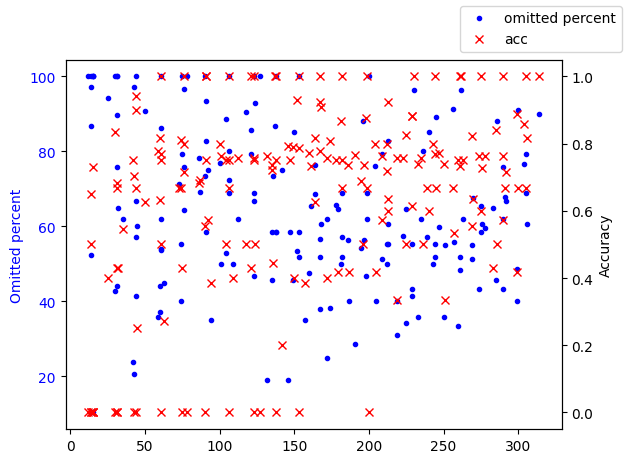

In [ ]:
# DataS: Test the stored data reading
import csv
import matplotlib.pyplot as plt
base_path1 = f"{base}dataS/"
flattened_size = [num for x in size_a for num in x]
flattened_acc = [num for x in acc_scores_a for num in x]
flattened_ops = [num for x in o_ps_a for num in x]
print(flattened_size)
print(flattened_acc)
print(flattened_ops)
# Plot
fig, ax1 = plt.subplots()
ax1.plot(flattened_size, flattened_ops, 'b.', label = 'omitted percent')
ax1.set_ylabel('Omitted percent',color='b')
ax2 = ax1.twinx()
ax1.tick_params(axis='y',labelcolor='b')
ax2.plot(flattened_size, flattened_acc, 'rx', label = 'acc')
ax2.set_xlabel('Number of training points')
ax2.set_ylabel('Accuracy')
fig.legend()
plt.show()
fig.savefig(f"{base_path1}dataS_SVM_scatter.png")

In [ ]:
def opt_ave_list(original_list, num_subgroups):
    # Calculate the number of elements per subgroup
    elements_per_subgroup = len(original_list) // num_subgroups

    # Create subgroups
    subgroups = [original_list[i:i+elements_per_subgroup] for i in range(0, len(original_list), elements_per_subgroup)]

    # Calculate average values for each nth element
    average_values = []
    for n in range(1, elements_per_subgroup + 1):
        avg = sum(subgroup[n - 1] for subgroup in subgroups) / num_subgroups
        average_values.append(avg)

    return average_values

# Example usage:
original_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
                 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
                 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]

num_subgroups = 2  # Change this to the desired number of subgroups
average_values = opt_ave_list(original_list, num_subgroups)
print(average_values)

[11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0]


[0.06570253 2.26290303 0.43068859]


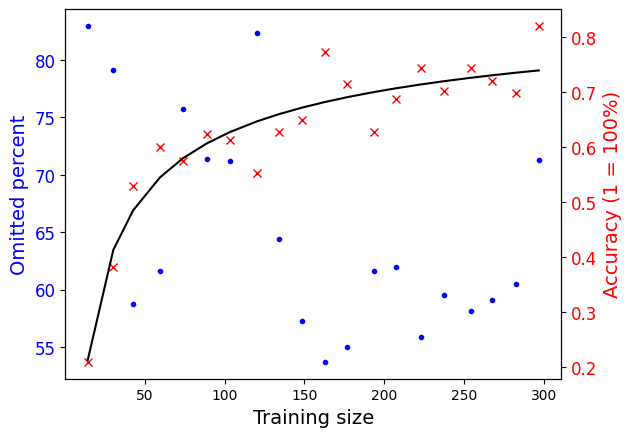

In [ ]:
# DataS: Plot with averaged values - baye new algorithm 2
# base = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/"
# base_path1 = f"{base}/dataS/svm_trial2/"
# size = read_csv(f"{base_path1}size.csv")
# acc_scores = read_csv(f"{base_path1}acc_scores.csv")
# auc_scores = read_csv(f"{base_path1}auc_scores.csv")
# print(size,"\n",acc_scores,"\n",auc_scores,"\n")
ave_size = opt_ave_list(flattened_size, 9)
ave_acc = opt_ave_list(flattened_acc, 9)
ave_ops = opt_ave_list(flattened_ops, 9)
# Plot
fig, ax1 = plt.subplots()
ax1.plot(ave_size, ave_ops, 'b.', label = 'omitted percent')
ax1.set_ylabel('Omitted percent',color='b',size=14)
ax1.set_xlabel('Training size',size=14)
ax1.tick_params(axis='y',labelcolor='b')
plt.yticks(fontsize=12)
ax2 = ax1.twinx()
ax2.plot(ave_size, ave_acc, 'rx', label = 'acc')
ax2.set_ylabel('Accuracy (1 = 100%)',color='r',size=14)
ax2.tick_params(axis='y',labelcolor='r')

#Fitted curve
from scipy.optimize import curve_fit
import numpy as np
def inverse_power(x, a, b, c):
    return (1-a)-b*(x**(-c))
pars, cov = curve_fit(f=inverse_power, xdata=ave_size, ydata=ave_acc, maxfev=5000,\
            p0=[0.1, 0.1, 0.1], bounds=(-np.inf, np.inf))
print(pars)
# Trial 2 Plot 2
# fig, ax1 = plt.subplots()
# # ax1.plot(size, acc_scores, 'r.')
ax2.plot(ave_size, inverse_power(ave_size, *pars), 'k-')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# fig.legend('centre')
plt.show()
fig.savefig(f"{base_path1}dataS_SVM_ave_scatter.png",bbox_inches='tight')

[0.06570253 2.26290303 0.43068859]


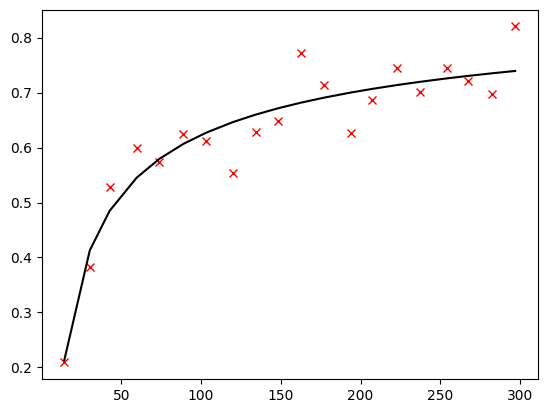

In [ ]:
# DataS: Find error curve of acc - baye new algorithm 2
from scipy.optimize import curve_fit
import numpy as np
def inverse_power(x, a, b, c):
    return (1-a)-b*(x**(-c))
pars, cov = curve_fit(f=inverse_power, xdata=ave_size, ydata=ave_acc, maxfev=5000,\
            p0=[0.1, 0.1, 0.1], bounds=(-np.inf, np.inf))
print(pars)
# Trial 2 Plot 2
fig, ax1 = plt.subplots()
# ax1.plot(size, acc_scores, 'r.')
ax1.plot(ave_size, ave_acc, 'rx')
ax1.plot(ave_size, inverse_power(ave_size, *pars), 'k-')

In [ ]:
# DataS: Find dataS for 90% acc - baye new algorithm 2
from scipy.optimize import fsolve
def func(x):
    return inverse_power(x, *pars)
def difference(x):
    return func(x) - 0.9
root = fsolve(difference, 300) # Find the root when the function is shifted by 0.9, initial value = 253

print(np.isclose(difference(root),0))  # func(root) should be almost 0.0.
print(root,'\n')
print(func(root))

[ True]
[16765.13349157] 

[0.9]


**Conclusion**: For SVM model with a 0.7 threshold, a training size bigger than 16765 may results in 90%+ accuracy!